In [1]:
import pysam
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

cml = mpl.cm.tab20.colors
colors = [list(c) for c in cml]

### AF histogram in Nanopore vs. Illumina

In [58]:
def calculate_af(ad):
    """Calculate allele frequency as max(AD) / sum(AD)."""
    if not ad:
        return None
    return max(ad) / sum(ad) if sum(ad) > 0 else None

def get_shared_het_sites(vcf1_path, vcf2_path, ancestor, sm1, sm2):
    """Get shared heterozygous sites from two VCF files."""
    vcf1 = pysam.VariantFile(vcf1_path)
    vcf1.subset_samples([ancestor, sm1])
    
    vcf2 = pysam.VariantFile(vcf2_path)
    vcf2.subset_samples([sm2])

    anc_afs = []
    ilu_afs = []
    ont_afs = []

    dc = {}
    
    # Iterate through records in the first VCF file
    for rec1 in vcf1:

        # Ancestor site
        gt = rec1.samples[ancestor].get("GT")
        if len(gt) <= 1 or None in gt:
            continue

        chrom, pos = rec1.chrom, rec1.pos
        if chrom not in dc.keys():
            dc[chrom] = {}

        if pos not in dc[chrom].keys():
            dc[chrom][pos] = {'anc':None, 'ilu':None, 'ont':None}

        anc_af = calculate_af(rec1.samples[ancestor].get('AD'))
        dc[chrom][pos]['anc'] = anc_af

        gt = rec1.samples[sm1].get("GT")
        if len(gt) <= 1 or None in gt:
            continue

        ilu_af = calculate_af(rec1.samples[sm1].get('AD'))
        dc[chrom][pos]['ilu'] = ilu_af

    # Iterate through records in the second VCF file
    for rec2 in vcf2:
        gt = rec2.samples[sm2].get("GT")
        if len(gt) <= 1 or None in gt:
            continue

        # Site is not shared
        chrom, pos = rec2.chrom, rec2.pos
        try:
            dc[chrom][pos]['ont'] = calculate_af(rec2.samples[sm2].get('AD'))
        except:
            continue

    return dc


# Define file paths
vcf1_path = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/jointgenotyping/merged.only_het.gets.bcf" # ILLUMINA +1 month
vcf2_path = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam.bcftools_mpileup.bcf" # NANOPORE +6 months

In [59]:
# Get shared heterozygous sites and their allele frequencies
sample1="P500_C18_E3"
sample2='/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam'
data = get_shared_het_sites(vcf1_path, vcf2_path, ancestor="ancestor", sm1=sample1, sm2=sample2)

In [67]:
dc = {
    'chr':[],
    'pos':[],
    'anc_af':[],
    'ilu_af':[],
    'ont_af':[],
}

for chrom, ps in data.items():
    for p, afs in ps.items():
        #print(afs)
        # Remove non-shared sites
        if any(af is None for af in afs.values()):
            continue

        dc['chr'].append(chrom)
        dc['pos'].append(p)
        dc['anc_af'].append(afs['anc'])
        dc['ilu_af'].append(afs['ilu'])
        dc['ont_af'].append(afs['ont'])

afdf = pd.DataFrame(dc)
afdf

,chr,pos,anc_af,ilu_af,ont_af
0,Chrom_3,4817,0.750000,0.954545,0.932271
1,Chrom_3,7253,0.773529,0.735016,0.638095
2,Chrom_3,11172,0.571429,0.571429,0.932203
3,Chrom_3,11184,0.500000,0.666667,0.966667
4,Chrom_3,11196,1.000000,1.000000,0.571429
...,...,...,...,...,...
1309188,Chrom_6,13877604,0.591111,1.000000,0.944444
1309189,Chrom_6,13877614,0.591111,1.000000,0.965517
1309190,Chrom_6,13877676,0.601990,0.982143,0.941176
1309191,Chrom_6,13877784,0.919708,1.000000,0.758621


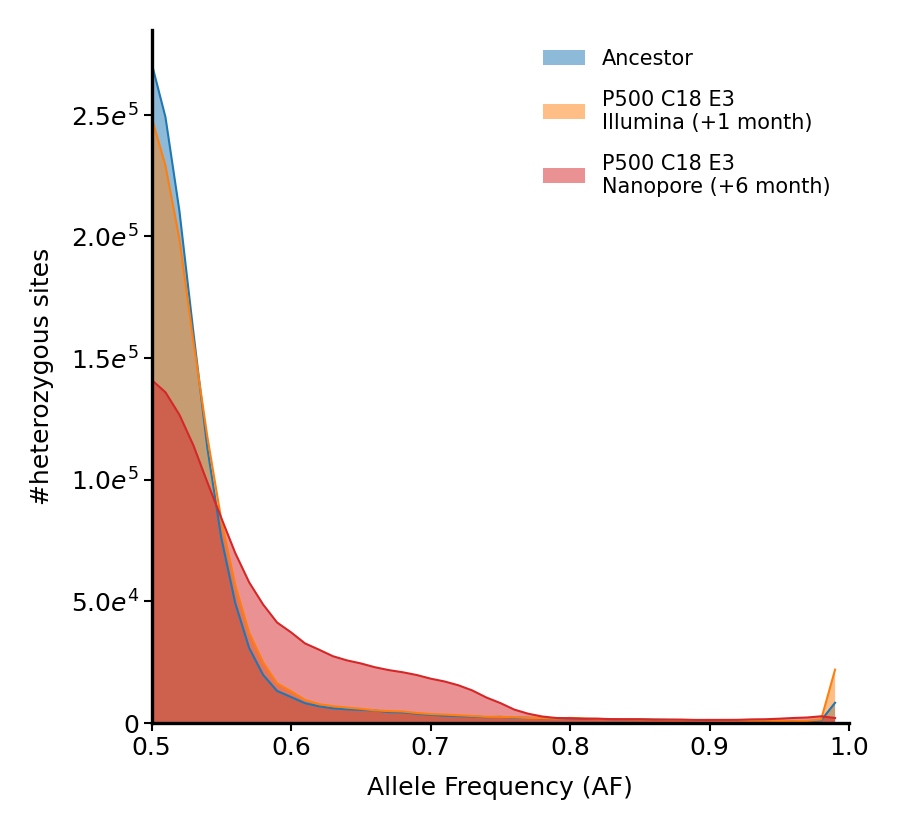

In [83]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

f0, b0 = np.histogram(afdf['anc_af'], bins=np.arange(0.0, 1.01, 0.01))
f1, b1 = np.histogram(afdf['ilu_af'], bins=np.arange(0.0, 1.01, 0.01))
f2, b2 = np.histogram(afdf['ont_af'], bins=np.arange(0.0, 1.01, 0.01))

ax.plot(b0[:-1], f0, color=colors[0], zorder=3, lw=0.5)
ax.fill_between(b0[:-1], f0, 0, fc=colors[0]+[0.5], lw=0, label="Ancestor", zorder=2)

ax.plot(b1[:-1], f1, color=colors[2], zorder=3, lw=0.5)
ax.fill_between(b1[:-1], f1, 0, fc=colors[2]+[0.5], lw=0, label="P500 C18 E3\nIllumina (+1 month)", zorder=2)

ax.plot(b2[:-1], f2, color=colors[6], zorder=3, lw=0.5)
ax.fill_between(b2[:-1], f2, 0, fc=colors[6]+[0.5], lw=0, label="P500 C18 E3\nNanopore (+6 month)", zorder=2)

ax.set_xlabel('Allele Frequency (AF)', fontsize=6)
ax.set_ylabel('#heterozygous sites', fontsize=6)

ax.spines[['top', 'right']].set_visible(False)
for spine in ax.spines.values():
    spine.set_zorder(3)
    
ax.legend(frameon=False, fontsize=5, labelspacing=1)
ax.set_xlim(0.5, 1.0)
ax.set_ylim(0, )


# Custom formatter function
def scientific_format(x, pos):
    if x == 0:
        return r"$0$"
    exponent = int(np.floor(np.log10(abs(x))))
    mantissa = x / 10**exponent
    return r"${:.1f}e^{{{}}}$".format(mantissa, exponent)

# Setting the custom formatter for both x and y axes
formatter = FuncFormatter(scientific_format)
ax.yaxis.set_major_formatter(formatter)

ax.tick_params(axis="both", width=0.5, labelsize=6, length=2, pad=1)

plt.show()

### Coverage shift in IR induced deletions (unique to P500C18E3) vs. ancestral deletions (already present in ancestor)

In [8]:
fcov_anc = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/coverage/ancestor.sorted.CALL.bam.cov.gz"
fcov_ilu = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/coverage/P500_C18_E3.sorted.CALL.bam.cov.gz"
fcov_ont = "/mnt/urbe2/disk3/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.cov.gz"

In [9]:
ca = pd.read_csv(fcov_anc, header=0, usecols=range(3), names=['chr', 'pos', 'cov'], sep='\t')

In [10]:
ci = pd.read_csv(fcov_ilu, header=0, usecols=range(3), names=['chr', 'pos', 'cov'], sep='\t')

In [11]:
co = pd.read_csv(fcov_ont, header=0, usecols=range(3), names=['chr', 'pos', 'cov'], sep='\t')

In [12]:
# Normalize
ca = ca.assign(norm=ca['cov'].div(ca['cov'].median()))
ci = ci.assign(norm=ci['cov'].div(ci['cov'].median()))
co = co.assign(norm=co['cov'].div(co['cov'].median()))

### Detect deletions larger than 10Kb with lower than 60% coverage

In [13]:
def find_deletions(df, window_size=10000, threshold=0.6):
    deletions = []
    start, end = None, None

    chroms = df['chr'].unique()

    for chrom in chroms:
        cdf = df.query('chr == @chrom')
    
        rolling_mean = cdf['norm'].rolling(window=window_size, min_periods=1).mean()
        for idx, value in enumerate(rolling_mean):
            if value <= threshold:
                if start is None:
                    start = df.iloc[idx]['pos']
                end = df.iloc[idx]['pos']
            else:
                if start is not None and (end - start) > window_size:
                    deletions.append((chrom, start, end))
                start, end = None, None
                
    return deletions

In [14]:
dels = find_deletions(ca)

In [15]:
dels_ilu = find_deletions(ci)

### Determine shared deletions

In [16]:
def compare_deletions(deletions1, deletions2):
    shared = []
    unique_t2 = []
    for d2 in deletions2:
        is_shared = any(d1[1] <= d2[2] and d1[2] >= d2[1] for d1 in deletions1)
        if is_shared:
            shared.append(d2)
        else:
            unique_t2.append(d2)
    return shared, unique_t2

In [17]:
shared, unique_t2 = compare_deletions(dels, dels_ilu)

In [18]:
total_size_shared = 0
for chrom, start, end in shared:
    total_size_shared += (end-start)
print(f"Shared deletions with ancestor: {len(shared)}, total spanned bp = {total_size_shared:,d}bp")

total_size_unique_t2 = 0
for chrom, start, end in unique_t2:
    total_size_unique_t2 += (end-start)
print(f"Shared deletions with ancestor: {len(unique_t2)}, total spanned bp = {total_size_unique_t2:,d}bp")

Shared deletions with ancestor: 196, total spanned bp = 9,084,648bp
Shared deletions with ancestor: 16, total spanned bp = 841,937bp


In [ ]:
evol_dc = {
    "chr":[],
    "start":[],
    "end":[],
    "is_ancestral":[],
    "A_mean":[],
    "A_std":[],
    "I_mean":[],
    "I_std":[],
    "O_mean":[],
    "O_std":[],
}

for chrom, start, end in shared:
    del_cov_anc = ca.query('chr == @chrom & pos >= @start & pos <= @end')
    del_cov_ilu = ci.query('chr == @chrom & pos >= @start & pos <= @end')
    del_cov_ont = co.query('chr == @chrom & pos >= @start & pos <= @end')

    evol_dc["chr"].append(chrom)
    evol_dc["start"].append(start)
    evol_dc["end"].append(end)
    evol_dc["is_ancestral"].append(True)
    evol_dc["A_mean"].append(del_cov_anc['norm'].mean())
    evol_dc["A_std"].append(del_cov_anc['norm'].std())
    evol_dc["I_mean"].append(del_cov_ilu['norm'].mean())
    evol_dc["I_std"].append(del_cov_ilu['norm'].std())
    evol_dc["O_mean"].append(del_cov_ont['norm'].mean())
    evol_dc["O_std"].append(del_cov_ont['norm'].std())

for chrom, start, end in unique_t2:
    del_cov_anc = ca.query('chr == @chrom & pos >= @start & pos <= @end')
    del_cov_ilu = ci.query('chr == @chrom & pos >= @start & pos <= @end')
    del_cov_ont = co.query('chr == @chrom & pos >= @start & pos <= @end')

    evol_dc["chr"].append(chrom)
    evol_dc["start"].append(start)
    evol_dc["end"].append(end)
    evol_dc["is_ancestral"].append(False)
    evol_dc["A_mean"].append(del_cov_anc['norm'].mean())
    evol_dc["A_std"].append(del_cov_anc['norm'].std())
    evol_dc["I_mean"].append(del_cov_ilu['norm'].mean())
    evol_dc["I_std"].append(del_cov_ilu['norm'].std())
    evol_dc["O_mean"].append(del_cov_ont['norm'].mean())
    evol_dc["O_std"].append(del_cov_ont['norm'].std())

In [ ]:
evol_df = pd.DataFrame(evol_dc)
evol_df

### Save results to file

In [113]:
evol_df.to_csv('ancestral_and_new_deletions_coverage_evolution.tsv', index=False, sep='\t')

### Plot

In [47]:
# read file:
evol_df = pd.read_csv('ancestral_and_new_deletions_coverage_evolution.tsv', sep='\t')

In [48]:
evol_df = evol_df.assign(t0t1=(evol_df['I_mean'] - evol_df['A_mean'])) # / evol_df['A_mean'])
evol_df = evol_df.assign(t0t2=(evol_df['O_mean'] - evol_df['A_mean'])) # / evol_df['A_mean'])
evol_df = evol_df.assign(t1t2=(evol_df['O_mean'] - evol_df['I_mean'])) # / evol_df['I_mean'])
evol_df

,chr,start,end,is_ancestral,A_mean,A_std,I_mean,I_std,O_mean,O_std,t0t1,t0t2,t1t2
0,Chrom_3,0,13479,True,0.478223,0.327870,0.472212,0.336596,0.461996,0.283667,-0.006012,-0.016228,-0.010216
1,Chrom_3,23173,39291,True,0.505186,0.294910,0.512283,0.275620,0.473743,0.275511,0.007097,-0.031443,-0.038540
2,Chrom_3,50194,84600,True,0.492638,0.265089,0.498866,0.264938,0.526637,0.214975,0.006228,0.033999,0.027771
3,Chrom_3,91120,103379,True,0.528947,0.269784,0.553750,0.289560,0.524183,0.251455,0.024802,-0.004764,-0.029567
4,Chrom_3,144299,234793,True,0.402678,0.170159,0.408031,0.177270,0.407987,0.161450,0.005353,0.005308,-0.000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,Chrom_4,3144979,3329014,False,1.034150,0.089456,0.543041,0.061592,0.746091,0.052601,-0.491108,-0.288058,0.203050
208,Chrom_4,13254175,13264263,False,0.766109,0.241651,0.598667,0.149021,0.573267,0.109218,-0.167443,-0.192842,-0.025399
209,Chrom_6,3831539,3941522,False,1.011686,0.204840,0.561075,0.200075,0.730322,0.065446,-0.450611,-0.281364,0.169247
210,Chrom_6,3951607,4104719,False,1.045566,0.087414,0.557782,0.056355,0.742011,0.048117,-0.487784,-0.303555,0.184229


In [49]:
from matplotlib.lines import Line2D
plt.rcParams['text.usetex'] = False
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

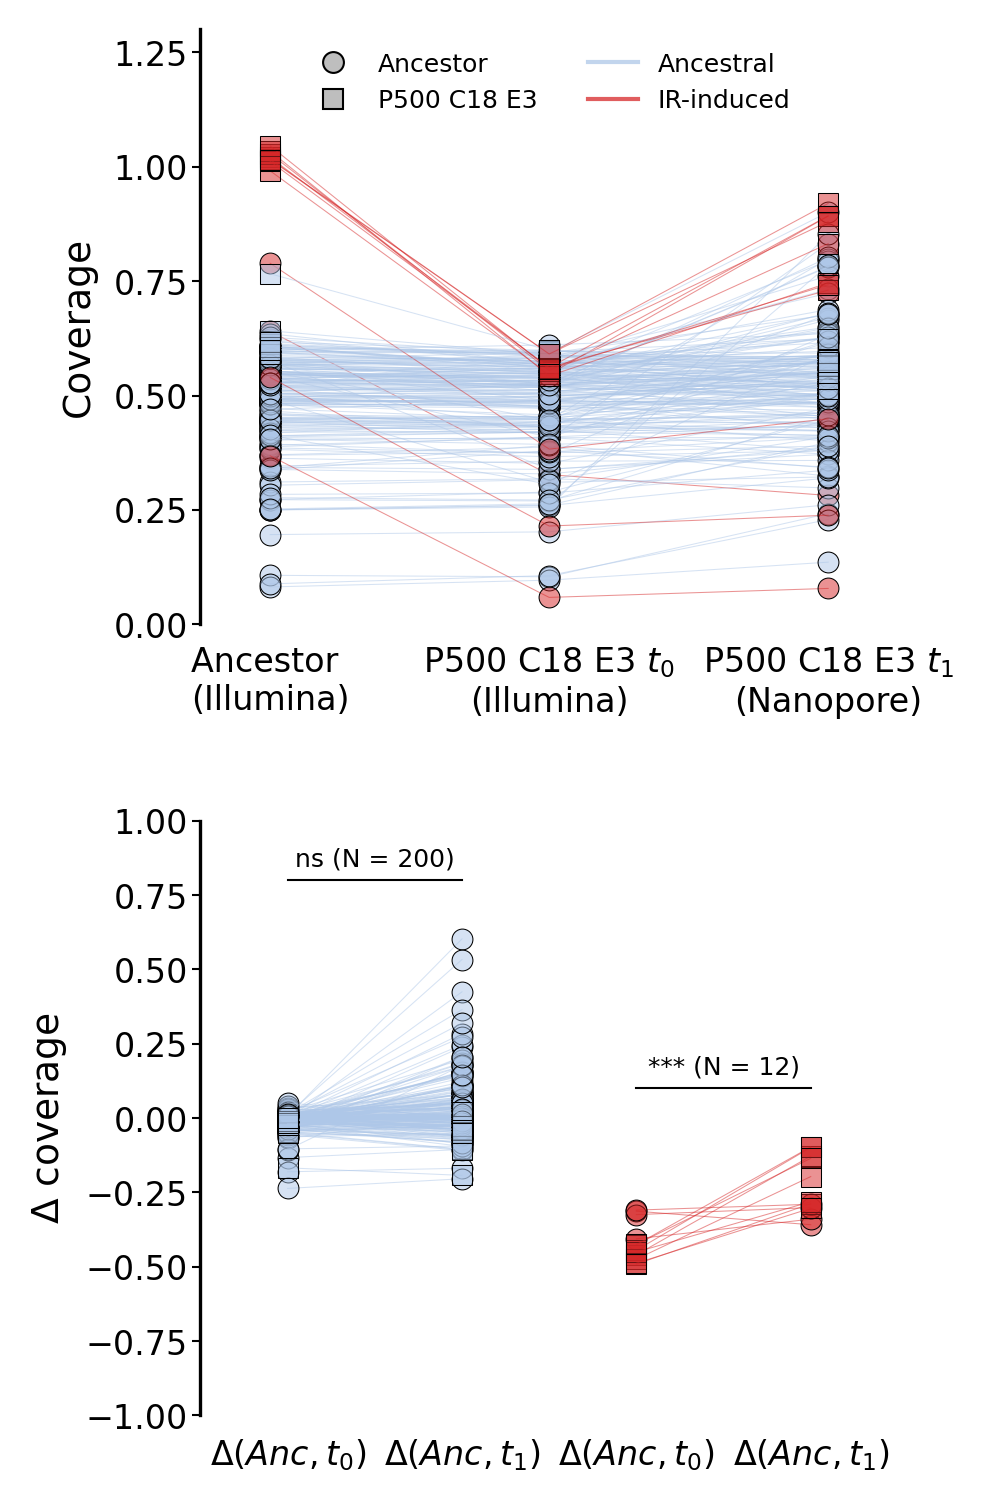

In [72]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(3,6), dpi=300)

ax = axs[0]
for i, row in evol_df.iterrows():

    is_shared = row['is_ancestral']
    changed_in_illumina = row['t0t1'] < -0.25
    
    color = colors[6] if changed_in_illumina else colors[1]
    x = [0, 1, 2]
    y = [row['A_mean'], row['I_mean'], row['O_mean']]

    #l = "Shared" if is_shared else "Post IR"
    m = "o" if is_shared else 's'
    ax.plot(x, y, lw=0.25, color=color+[0.5], ms=5, mfc=color+[0.5], marker=m, mec='k', mew=0.25)

ax.set_ylim(0, 1.3)

legend_elements = [
    Line2D([0], [0], lw=0, ms=5, mfc=colors[14]+[0.5], marker='o', mec='k', mew=0.5, label='Ancestor'),
    Line2D([0], [0], lw=0, ms=5, mfc=colors[14]+[0.5], marker='s', mec='k', mew=0.5, label='P500 C18 E3'),
    #Line2D([0], [0], lw=1, color=colors[1]+[0.75], marker=None, label="Ancestor $ \\simeq t_{1}$ (Ancestral)"),
    #Line2D([0], [0], lw=1, color=colors[6]+[0.75], marker=None, label="Ancestor $ > t_{1}$ (IR induced)"),
    Line2D([0], [0], lw=1, color=colors[1]+[0.75], marker=None, label="Ancestral"),
    Line2D([0], [0], lw=1, color=colors[6]+[0.75], marker=None, label="IR-induced"),
]
ax.legend(handles=legend_elements, fontsize=6, frameon=False, ncol=2, loc="upper center")
ax.set_ylabel('Coverage', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(["Ancestor \n(Illumina)", "P500 C18 E3 $t_{0}$\n(Illumina)", "P500 C18 E3 $t_{1}$\n(Nanopore)"])
ax.set_xlim(-0.25, 2.25)
ax.set_yticks(np.arange(0,1.3,0.25))

ax = axs[1]
for i, row in evol_df.iterrows():

    is_shared = row['is_ancestral']
    changed_in_illumina = row['t0t1'] < -0.25
    color = colors[6] if changed_in_illumina else colors[1]
    m = "o" if is_shared else 's'

    x = [1, 1.5] if changed_in_illumina else [0, 0.5]
    y = [row['t0t1'], row['t0t2']]
    ax.plot(x, y, lw=0.25, color=color+[0.5], ms=5, mfc=color+[0.5], marker=m, mec='k', mew=0.25)

ax.set_xticks([0, 0.5, 1, 1.5])
ax.set_xticklabels(['$\\Delta\\left(Anc, t_{0}\\right)$', '$\\Delta\\left(Anc, t_{1}\\right)$', '$\\Delta\\left(Anc, t_{0}\\right)$', '$\\Delta\\left(Anc, t_{1}\\right)$'])
ax.set_ylabel('$\\Delta$ coverage', fontsize=9)

ax.set_ylim(-1, 1.0)

for ax in axs:
    ax.tick_params(axis='y', labelsize=8, width=0.5, pad=1, length=2)
    ax.tick_params(axis='x', labelsize=8, width=0, pad=5, length=0)
    ax.spines[['top', 'bottom', 'right']].set_visible(False)

ax.plot([0,0.5], [0.8,0.8], color='k', lw=0.5)
ax.text(x=0.25, y=0.83, ha='center', va='bottom', s='ns (N = 200)', fontsize=6)

ax.plot([1,1.5], [0.1,0.1], color='k', lw=0.5)
ax.text(x=1.25, y=0.13, ha='center', va='bottom', s='*** (N = 12)', fontsize=6)

ax.set_xlim(-0.25, 1.75)

fig.subplots_adjust(hspace=0.33)

plt.show()

In [60]:
from scipy.stats import ttest_ind
evol_df = evol_df.assign(changed_t0t1 = evol_df['t0t1'] < -0.25)

nano_v_anc_ancestral = evol_df.query('not changed_t0t1')['t0t2']
nano_v_ilu_ancestral = evol_df.query('not changed_t0t1')['t1t2']
print(f"N = {len(nano_v_ilu_ancestral)}")

nano_v_anc_IR_induced = evol_df.query('changed_t0t1')['t0t2']
nano_v_ilu_IR_induced = evol_df.query('changed_t0t1')['t1t2']
print(f"N = {len(nano_v_ilu_IR_induced)}")

N = 200
N = 12


In [61]:
t_stat, p_value = ttest_ind(nano_v_anc_ancestral, nano_v_ilu_ancestral, equal_var=False)
print(t_stat, p_value)

-1.082445160887611 0.279713525790459


In [62]:
t_stat, p_value = ttest_ind(nano_v_anc_IR_induced, nano_v_ilu_IR_induced, equal_var=False)
print(t_stat, p_value)

-8.58722124889073 4.2075068793030156e-08
